In [1]:
import os
import sys
sys.path.insert(0, os.path.relpath('../../../../..')) 



In [2]:
from recidiviz.calculator.modeling.population_projection.super_simulation.super_simulation_factory import SuperSimulationFactory
from recidiviz.calculator.modeling.population_projection.spark_policy import SparkPolicy
from recidiviz.calculator.modeling.population_projection.transition_table import TransitionTable
from recidiviz.calculator.modeling.population_projection.utils.transitions_utils import TransitionTableType
from functools import partial
import pandas as pd
%config Completer.use_jedi = False

In [4]:
path_from_state_folder = 'WV/HB_2257/WV_hb2257_model_inputs.yaml'
display_compartments = ['release', 'prison_new_crime', 'prison_tech_rev']
test_sim = SuperSimulationFactory.build_super_simulation('../state/' + path_from_state_folder)
# test_sim.simulate_baseline(display_compartments)

/Users/pacopoler/.local/share/virtualenvs/pulse-data-Jd9N3JcA/lib/python3.8/site-packages/google/cloud/bigquery/table.py:1767: UserWarning: A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.
  record_batch = self.to_arrow(


outflows_data returned 54 results
transitions_data returned 75 results
total_population_data returned 0 results


initialization time:  6.290617942810059
initialization time:  5.425053119659424
simulation_time:  6.556541204452515
simulation_time:  6.274194955825806


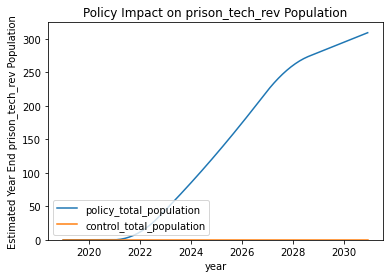

In [27]:
# Policy Option Methods
technical_revocation_rate = 0.2852883733
new_offense_revocation_rate = 0.268
RETROACTIVE = False

def shift_from_full_release_to_re_incarceration():
    return partial(TransitionTable.reallocate_outflow, 
                   reallocation_df=pd.DataFrame({
                       'outflow':['full_release'],
                       'affected_fraction': [technical_revocation_rate / (1 - new_offense_revocation_rate)],
                       'new_outflow': ['prison_new_crime']
                   }),
                   reallocation_type='*',
                   retroactive=RETROACTIVE)

def shift_from_new_rev_to_technical_rev():
    return partial(TransitionTable.reallocate_outflow, 
                   reallocation_df=pd.DataFrame({
                       'outflow':['prison_new_crime'],
                       'affected_fraction': [technical_revocation_rate / (technical_revocation_rate + new_offense_revocation_rate)],
                       'new_outflow': ['prison_tech_rev']
                   }),
                   reallocation_type='+',
                   retroactive=RETROACTIVE)


policy_list = [
    SparkPolicy(policy_fn=shift_from_full_release_to_re_incarceration(),
                spark_compartment='release',
                sub_population={'age': 'x'},
                policy_ts=24,
                apply_retroactive=False),
    SparkPolicy(policy_fn=shift_from_new_rev_to_technical_rev(),
                spark_compartment='release',
                sub_population={'age': 'x'},
                policy_ts=24,
                apply_retroactive=False)
]
    
test_results = test_sim.simulate_policy(policy_list, 'prison_tech_rev')

In [17]:
transitions = test_sim.simulator.pop_simulations['policy'].sub_simulations['x'].simulation_compartments['release'].compartment_transitions.transition_tables[24]
transitions.unnormalize_table(TransitionTableType.AFTER)
transitions.unnormalize_table(TransitionTableType.BEFORE)

[i.sum(axis=0) for i in transitions.transition_dfs.values()]

[outflow_to
 full_release        0.732002
 prison_new_crime    0.267998
 dtype: float64,
 outflow_to
 full_release        0.446713
 prison_new_crime    0.267999
 prison_tech_rev     0.285288
 dtype: float64,
 outflow_to
 full_release         0.843429
 prison_new_crime     4.292536
 remaining           65.864035
 dtype: float64]

In [20]:
test_sim.simulator.pop_simulations['policy'].sub_simulations['x'].simulation_compartments['prison_tech_rev'].compartment_transitions.historical_outflows



,simulation_tag,compartment_duration,compartment,outflow_to,total_population,crime,crime_type,age,race,date_created
1,wv_prison_p1,21.0,prison_tech_rev,release,1.0,None,None,x,None,2021-04-07 03:00:05.177885+00:00


In [28]:
simulation_tag = 'WV_HB_2257'
test_sim.upload_policy_simulation_results_to_bq(simulation_tag)

{'spending_diff':             release prison_new_crime  prison_tech_rev full_release
 year                                                              
 2019.000000     0.0              0.0              0.0          0.0
 2019.083333     0.0              0.0              0.0          0.0
 2019.166667     0.0              0.0              0.0          0.0
 2019.250000     0.0              0.0              0.0          0.0
 2019.333333     0.0              0.0              0.0          0.0
 ...             ...              ...              ...          ...
 2030.583333     0.0      -211.485131 -39924648.203797          0.0
 2030.666667     0.0      -215.078915 -40583686.903728          0.0
 2030.750000     0.0      -218.694872 -41245455.671463          0.0
 2030.833333     0.0      -222.332923 -41909952.028694          0.0
 2030.916667     0.0       -225.99298 -42577172.420153          0.0
 
 [144 rows x 4 columns],
 'compartment_life_years_diff':                 release prison_new_crime